In [1]:
# Import packages
import pathlib
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers, applications
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load data
FILE_DIR = r'../dataset'
DATA_PATH = pathlib.Path(FILE_DIR)

SEED = 12345
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
train_data = image_dataset_from_directory(DATA_PATH,
                                          validation_split=0.2,
                                          subset='training',
                                          seed=SEED,
                                          shuffle=True,
                                          image_size=IMG_SIZE,
                                          batch_size=BATCH_SIZE
                                          )

validation_data = image_dataset_from_directory(DATA_PATH,
                                               validation_split=0.2,
                                               subset='validation',
                                               seed=SEED,
                                               shuffle=True,
                                               image_size=IMG_SIZE,
                                               batch_size=BATCH_SIZE)

Found 40000 files belonging to 2 classes.
Using 32000 files for training.
Found 40000 files belonging to 2 classes.
Using 8000 files for validation.


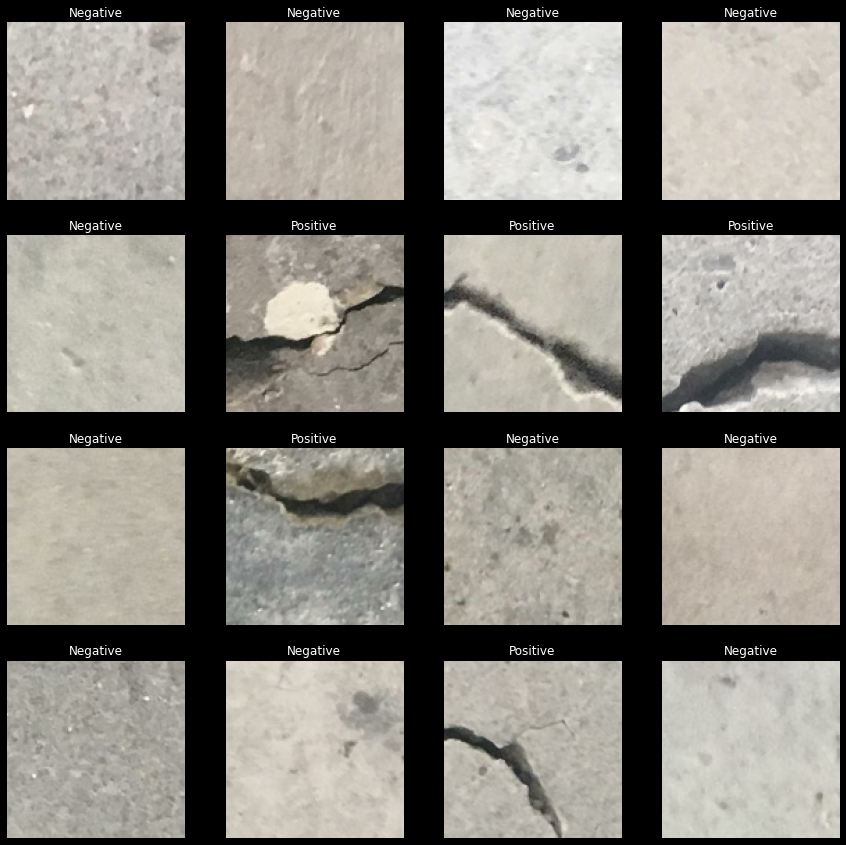

In [4]:
# Split validation into val &test
val_batches = tf.data.experimental.cardinality(validation_data)
test_data = validation_data.take(val_batches//5)
val_data = validation_data.skip(val_batches//5)

# Display examples of data
class_names = train_data.class_names

plt.figure(figsize=(15, 15))
for images, labels in train_data.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
# Create Prefetch for train,test,val data
AUTOTUNE = tf.data.AUTOTUNE
pf_train = train_data.prefetch(buffer_size=AUTOTUNE)
pf_test = test_data.prefetch(buffer_size=AUTOTUNE)
pf_val = val_data.prefetch(buffer_size=AUTOTUNE)

In [6]:
# Augmentation layer
data_augmentation = tf.keras.Sequential()
data_augmentation.add(layers.RandomFlip('horizontal_and_vertical'))
data_augmentation.add(layers.RandomRotation(0.2))

In [7]:

# Feature extraction layer
# (a) Input processing
preprocess_input = applications.resnet50.preprocess_input

# (b) create base model using ResNet50
IMG_SHAPE = IMG_SIZE + (3,)
base_model = applications.ResNet50(input_shape=IMG_SHAPE,
                                   include_top=False,
                                   weights='imagenet')

# (c) Freeze layers
base_model.trainable = False
base_model.summary()

# (d) Classification layer
nClass = len(class_names)

global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(nClass, activation='softmax')

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [8]:
# Chain layers with Functional api
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x)
x = global_avg(x)
outputs = output_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()
img_file = '../public/model_plot.png'
plot_model(model, to_file=img_file, show_shapes=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098  

FileNotFoundError: [Errno 2] No such file or directory: 'public/model_plot.png'

In [ ]:
# Compile
lr_schedule = optimizers.schedules.CosineDecay(0.001, 500)
optimizer = optimizers.Adam(learning_rate=lr_schedule)
loss = losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
# Train Model
EPOCHS = 5
history = model.fit(pf_train, validation_data=(pf_val), epochs=EPOCHS)

In [ ]:
# Finetune base model layer
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [ ]:
# Recompile model
optimizer = optimizers.RMSprop(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
# Continue model training
fine_tune_epoch = 1
NEW_EPOCH = EPOCHS + fine_tune_epoch

history_fine = model.fit(pf_train,
                         validation_data=pf_val,
                         epochs=NEW_EPOCH,
                         initial_epoch=history.epoch[-1])

In [ ]:
# Model evaluation
test_loss, test_accuracy = model.evaluate(pf_test)
print("====================MODEL EVALUATION======================")
print(f"Test Loss : {test_loss}")
print(f"Test Accuracy : {test_accuracy}")

In [ ]:
# Make predictions
image_batch, label_batch = pf_test.as_numpy_iterator().next()
predicted_labels = np.argmax(model.predict(image_batch), axis=1)

In [ ]:
# Compare label against predictions
label_vs_prediction = np.transpose(np.vstack((label_batch, predicted_labels)))